In [44]:
!pip install gower
# 必要なライブラリーの読み込み
import pandas as pd
import numpy as np
import gower
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
# グラフのスタイルとサイズ
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
data = pd.read_csv("/content/drive/MyDrive/LSTMの実装：引越し需要予測/20221118.csv")
data.head()

,Unnamed: 0,datetime,y,client,close,price_am,price_pm,year,month,day,Weekday,holidays
0,0,2010-07-01,17,0,0,-1,-1,2010,7,1,Thursday,0
1,1,2010-07-02,18,0,0,-1,-1,2010,7,2,Friday,0
2,2,2010-07-03,20,0,0,-1,-1,2010,7,3,Saturday,0
3,3,2010-07-04,20,0,0,-1,-1,2010,7,4,Sunday,0
4,4,2010-07-05,14,0,0,-1,-1,2010,7,5,Monday,0


In [46]:
# 2011年４月１日以降のデータを対象にしてベースモデルを作成する
data = data[data["datetime"] >= "2011-04-01" ]

In [47]:
cluster_data = data[["y","client","close","price_am","price_pm","holidays"]]

In [48]:
# デンドログラム作成関数（Plot Hierarchical Clustering Dendrogram）
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)


In [49]:
cluster_data.head()

,y,client,close,price_am,price_pm,holidays
274,48,0,0,4,2,0
275,29,0,0,5,4,0
276,28,0,0,3,3,0
277,23,0,0,2,1,0
278,25,0,0,1,1,0


In [50]:
scaled_dt = StandardScaler().fit_transform(cluster_data[["y","price_am","price_pm"]])
category_dt = cluster_data[["client" , "close" , "holidays"]].values
scaled = np.concatenate([scaled_dt , category_dt] , axis=1)

columns= ["y","price_am","price_pm","client" , "close" , "holidays"]
scaled_data = pd.DataFrame(scaled , columns=columns)


scaled_data[["client" , "close" , "holidays"]] = scaled_data[["client" , "close" , "holidays"]].astype("str")

scaled_data.dtypes

y           float64
price_am    float64
price_pm    float64
client       object
close        object
holidays     object
dtype: object

In [51]:
# 距離の計算
distance_matrix = gower.gower_matrix(scaled_data)
distance_matrix

array([[0.        , 0.11238532, 0.08613659, ..., 0.29867482, 0.32798165,
        0.33715597],
       [0.11238532, 0.        , 0.08486239, ..., 0.29994902, 0.2737003 ,
        0.2828746 ],
       [0.08613659, 0.08486239, 0.        , ..., 0.32925585, 0.3585627 ,
        0.367737  ],
       ...,
       [0.29867482, 0.29994902, 0.32925585, ..., 0.        , 0.02930683,
        0.03848114],
       [0.32798165, 0.2737003 , 0.3585627 , ..., 0.02930683, 0.        ,
        0.00917431],
       [0.33715597, 0.2828746 , 0.367737  , ..., 0.03848114, 0.00917431,
        0.        ]], dtype=float32)

In [52]:
# 階層型クラスター分析の実施
model = AgglomerativeClustering(compute_distances=True)
model = model.fit(distance_matrix)

/usr/local/lib/python3.8/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [53]:
# # デンドログラムの描写（フルバージョン）
# plot_dendrogram(model)

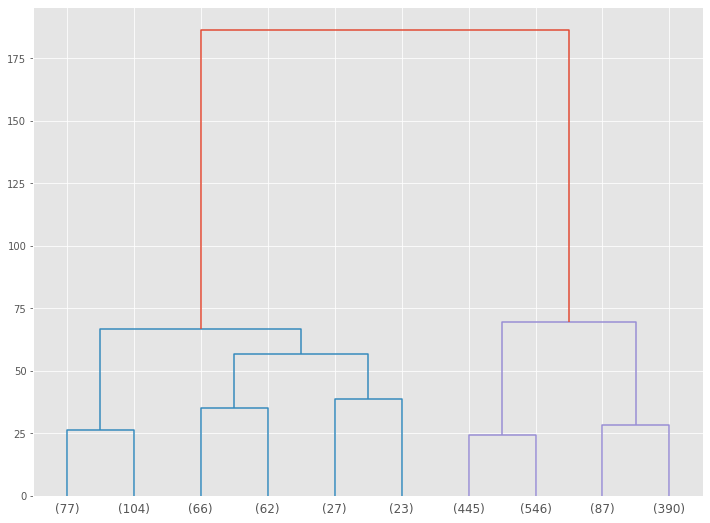

In [54]:
# デンドログラムの描写（クラスター数：約20）
plot_dendrogram(model,truncate_mode='lastp',p=10)


In [55]:
# 階層型クラスター分析の実施
model = AgglomerativeClustering(compute_distances=True ,n_clusters=2)
model = model.fit(distance_matrix)

/usr/local/lib/python3.8/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [56]:
# クラスターID列を元データに追加
data["cluster"] = model.labels_
data.head()

,Unnamed: 0,datetime,y,client,close,price_am,price_pm,year,month,day,Weekday,holidays,cluster
274,274,2011-04-01,48,0,0,4,2,2011,4,1,Friday,0,1
275,275,2011-04-02,29,0,0,5,4,2011,4,2,Saturday,0,1
276,276,2011-04-03,28,0,0,3,3,2011,4,3,Sunday,0,1
277,277,2011-04-04,23,0,0,2,1,2011,4,4,Monday,0,0
278,278,2011-04-05,25,0,0,1,1,2011,4,5,Tuesday,0,0


In [57]:
data.to_csv("/content/drive/MyDrive/LSTMの実装：引越し需要予測/after_cluster_data2.csv")

In [59]:
# cluster 0の要素にholidaysが入っていない
# cluster 1の要素の中に全てのholidaysが入っている

data.groupby(["cluster"])["y"].mean()

cluster
0    33.794959
1    47.665738
Name: y, dtype: float64

In [63]:
data.groupby(["cluster","holidays"])["y"].count()

cluster  holidays
0        0           1468
1        0            274
         1             85
Name: y, dtype: int64

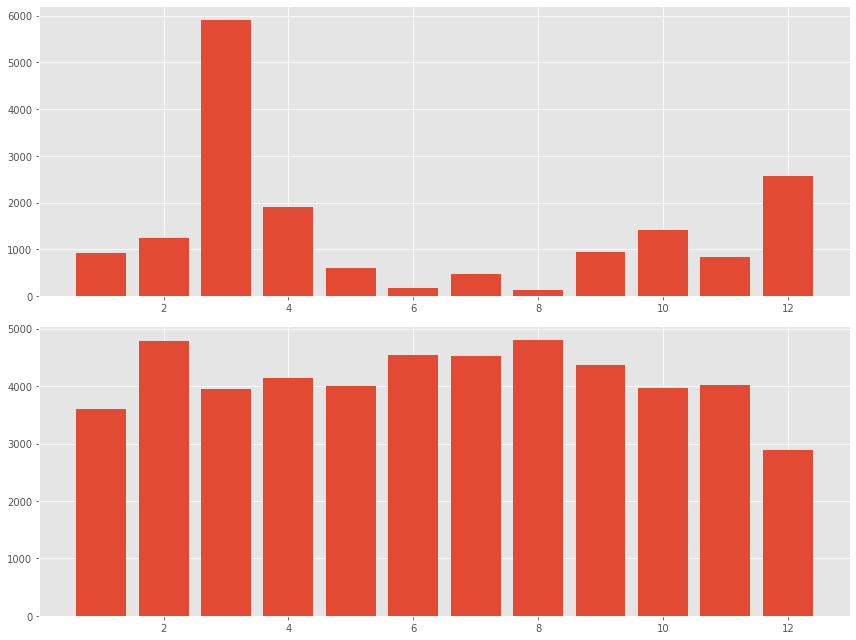

In [89]:
x_1 = data.query('cluster == 1').groupby("month")["y"].sum().index
y_1 = data.query('cluster == 1').groupby("month")["y"].sum()

x_0 = data.query('cluster == 0').groupby("month")["y"].sum().index
y_0 = data.query('cluster == 0').groupby("month")["y"].sum()

fig = plt.figure()

ax1 = fig.add_subplot(2, 1, 1)
ax1.bar(x_1,y_1)


ax2 = fig.add_subplot(2, 1, 2)
ax2.bar(x_0,y_0)

# show plots
fig.tight_layout()
fig.show()

In [107]:
# c_0_am =data.query('cluster == 0').groupby("price_am")["price_am"].count().values
# c_0_pm =data.query('cluster == 0').groupby("price_pm")["price_pm"].count().values

# c_1_am =data.query('cluster == 1').groupby("price_am")["price_am"].count().values
# c_1_pm =data.query('cluster == 1').groupby("price_pm")["price_pm"].count().values

# concat_0 = np.concatenate(c_0_am , c_0_pm , axis=1)
# concat_1 = np.concatenate(c_1_am , c_1_pm ,axis=1)

# columns_0 = [c_0_am , c_0_pm]
# columns_1 = [c_1_am , c_1_pm] 

# price_am_compare = pd.DataFrame(concat_0 , columns=columns_0 )
# price_pm_compare = pd.DataFrame(concat_1 , columns=columns_1 )

# price_am_compare.head()